# GPT-4 mini NLU 成本评估实验

本 Notebook 复现并记录使用 ChatGPT-4 mini（`gpt-4o-mini`）对 `experiment/nlu_eval_dataset_strict.csv` 中 50 条问句进行意图分类的全过程，包含提示词、批量推理、评估指标以及推理成本估算。


## 实验目标与产出
- 验证 GPT-4 mini 对五类意图（`RAG / SQL_tool / RAG+SQL_tool / planner / nlu`）的分类准确率
- 生成可回溯的推理记录（含原问题、预测、参考标签、token 统计）
- 计算 Prompt / Completion token 成本，输出总费用与单问成本
- 为误分类样本提供 case study，辅助改进 NLU 模型或提示词


## 1. 环境与依赖
在执行之前请确认当前 Conda/venv 已激活，并按照需要安装依赖。若环境中已安装，可跳过此单元。


In [1]:
import sys
sys.executable


'/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/bin/python'

In [2]:
# 如果环境中已具备依赖，可跳过执行本单元
%pip install -q -U openai pandas scikit-learn seaborn matplotlib tqdm tenacity python-dotenv



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
from __future__ import annotations

import json
import os
import time
from pathlib import Path
from typing import Any, Dict
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from openai import OpenAI
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ---- 路径、模型与费用配置 ----
NOTEBOOK_DIR = Path.cwd()
DATA_PATH = None
for candidate in [
    NOTEBOOK_DIR / "nlu_eval_dataset_strict.csv",
    NOTEBOOK_DIR / "experiment" / "nlu_eval_dataset_strict.csv",
    NOTEBOOK_DIR.parent / "experiment" / "nlu_eval_dataset_strict.csv",
]:
    if candidate.exists():
        DATA_PATH = candidate
        break
if DATA_PATH is None:
    raise FileNotFoundError("无法定位 experiment/nlu_eval_dataset_strict.csv，请确认 Notebook 运行目录")

EXPERIMENT_DIR = DATA_PATH.parent
RESULTS_DIR = EXPERIMENT_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CACHE_PATH = RESULTS_DIR / "nlu_eval_gpt4mini_cache.jsonl"
OUTPUT_PATH = RESULTS_DIR / "nlu_eval_strict_gpt4mini_results.csv"
MODEL_NAME = "gpt-4o-mini"  # ChatGPT-4 mini API
PRICE_PROMPT_PER_1K = 0.15 / 1000   # USD per 1K prompt tokens（示例价格，运行前与最新文档核对）
PRICE_COMPLETION_PER_1K = 0.60 / 1000  # USD per 1K completion tokens
VALID_INTENTS = ["RAG", "SQL_tool", "RAG+SQL_tool", "planner", "nlu"]

load_dotenv()

api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise EnvironmentError("请在 .env 中设置 OPENAI_API_KEY 再运行本 Notebook")

client = OpenAI(api_key=api_key)
print(f"✅ OpenAI 客户端初始化完成，数据集路径：{DATA_PATH}")



✅ OpenAI 客户端初始化完成，数据集路径：/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment/nlu_eval_dataset_strict.csv


## 2. 数据加载与快速检查


In [3]:
%pwd

'/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment'

In [4]:
df = pd.read_csv(DATA_PATH)
print(f"样本量：{len(df)} 条")
display(df.head())
print("标签分布：")
display(df['label'].value_counts())


样本量：50 条


,text,image_uri,label,pred_intent
0,Describe the correct process for trimming park...,NaN,RAG,RAG
1,How should mowing blades be adjusted for safety?,NaN,RAG,RAG
2,What are the basic turf maintenance rules for ...,NaN,RAG,RAG+SQL_tool
3,Give me the official mowing protocol for publi...,NaN,RAG,RAG
4,Outline how to prepare turf before large events.,NaN,RAG,RAG


标签分布：


label
RAG             10
SQL_tool        10
RAG+SQL_tool    10
RAG+CV_tool     10
CV_tool         10
Name: count, dtype: int64

## 3. 提示词与辅助函数
该数据集要求模型仅输出五类意图之一，若需要多标签（如 `RAG+SQL_tool`），要求模型严格按 `+` 连接的顺序返回。下面定义意图描述、系统提示词以及通用工具函数。


In [8]:
INTENT_DEFINITIONS = {
    "RAG": "围绕公园维护的文字指引、流程、安全标准或尺寸规范等检索需求",
    "SQL_tool": "只需要结构化查询结果（聚合/排名/查表），不需要额外解释",
    "RAG+SQL_tool": "既要查询数据又要结合规程/政策做解释或比较",
    "RAG+CV_tool": "需要同时使用图片视觉判断与文字规范给出建议",
    "CV_tool": "仅依赖图像本身做判断，不引用文本或政策"
}

intent_desc = ", ".join([f"{k}: {v}" for k, v in INTENT_DEFINITIONS.items()])
SYSTEM_PROMPT = f"""你是一名 GPT-4 迷你模型，负责对公园维护问句进行意图分类。
可用意图: {intent_desc}.

严格要求:
1. 只输出一个字符串，为上述意图之一或组合（例如 RAG+SQL_tool）。
2. 不添加额外解释或标点。
3. 若问题与意图定义都不匹配，返回最接近的类别并保持一致性。
"""

print(SYSTEM_PROMPT)



你是一名 GPT-4 迷你模型，负责对公园维护问句进行意图分类。
可用意图: RAG: 围绕公园维护的文字指引、流程、安全标准或尺寸规范等检索需求, SQL_tool: 只需要结构化查询结果（聚合/排名/查表），不需要额外解释, RAG+SQL_tool: 既要查询数据又要结合规程/政策做解释或比较, RAG+CV_tool: 需要同时使用图片视觉判断与文字规范给出建议, CV_tool: 仅依赖图像本身做判断，不引用文本或政策.

严格要求:
1. 只输出一个字符串，为上述意图之一或组合（例如 RAG+SQL_tool）。
2. 不添加额外解释或标点。
3. 若问题与意图定义都不匹配，返回最接近的类别并保持一致性。



In [16]:
INTENT_DEFINITIONS_EN = {
    "RAG": "Textual guidance / procedures / standards such as SOPs, safety rules, field dimensions",
    "SQL_tool": "Structured results only (aggregations/ranking/lookups) with zero commentary",
    "RAG+SQL_tool": "Needs SQL data plus interpretation grounded in policies or standards",
    "RAG+CV_tool": "Requires visual inspection plus textual guidance references",
    "CV_tool": "Pure visual judgment without citing textual policies",
}

intent_desc_en = ", ".join([f"{k}: {v}" for k, v in INTENT_DEFINITIONS_EN.items()])
SYSTEM_PROMPT_EN = f"""You are a GPT-4 mini model that classifies parks-maintenance questions into intents.
Available intents: {intent_desc_en}.

Rules:
1. Output a single string exactly matching one intent or combo (e.g., RAG+SQL_tool).
2. Do not add explanations, punctuation, or extra tokens.
3. If no intent is perfect, pick the closest option consistently.
"""

print(SYSTEM_PROMPT_EN)



You are a GPT-4 mini model that classifies parks-maintenance questions into intents.
Available intents: RAG: Textual guidance / procedures / standards such as SOPs, safety rules, field dimensions, SQL_tool: Structured results only (aggregations/ranking/lookups) with zero commentary, RAG+SQL_tool: Needs SQL data plus interpretation grounded in policies or standards, RAG+CV_tool: Requires visual inspection plus textual guidance references, CV_tool: Pure visual judgment without citing textual policies.

Rules:
1. Output a single string exactly matching one intent or combo (e.g., RAG+SQL_tool).
2. Do not add explanations, punctuation, or extra tokens.
3. If no intent is perfect, pick the closest option consistently.



In [17]:
def normalize_intent(value: str) -> str:
    """归一化模型输出/标签，确保大小写一致并去除多余空格。"""
    if not isinstance(value, str):
        return ""
    cleaned = value.strip()
    cleaned = cleaned.replace(" ", "")
    cleaned = cleaned.replace("SQLTool", "SQL_tool")
    return cleaned


def _to_jsonable(value: Any):
    if hasattr(value, "model_dump"):
        return value.model_dump()
    if isinstance(value, dict):
        return {k: _to_jsonable(v) for k, v in value.items()}
    if isinstance(value, list):
        return [_to_jsonable(v) for v in value]
    return value


def load_cache(path: Path) -> Dict[str, Dict[str, Any]]:
    if not path.exists():
        return {}
    cache: Dict[str, Dict[str, Any]] = {}
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            try:
                item = json.loads(line)
                cache[item["text"]] = item
            except json.JSONDecodeError:
                continue
    return cache


def save_cache(path: Path, cache: Dict[str, Dict[str, Any]]) -> None:
    with path.open("w", encoding="utf-8") as f:
        for item in cache.values():
            serialized = _to_jsonable(item)
            f.write(json.dumps(serialized, ensure_ascii=False) + "\n")



In [18]:
def call_gpt4_mini(question: str,
                   temperature: float = 0.0,
                   max_retries: int = 3,
                   sleep_base: float = 1.5) -> Dict[str, Any]:
    """封装 GPT-4 mini Responses API 调用，并带指数退避重试。"""
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question},
    ]

    last_error: Exception | None = None
    for attempt in range(1, max_retries + 1):
        try:
            response = client.responses.create(
                model=MODEL_NAME,
                temperature=temperature,
                input=messages,
            )
            output_text = response.output_text.strip()
            usage_obj = getattr(response, "usage", None)
            usage = usage_obj.model_dump() if usage_obj else {}
            return {
                "output": output_text,
                "usage": usage,
                "response": response.model_dump(),
                "timestamp": time.time(),
            }
        except Exception as exc:  # noqa: BLE001
            last_error = exc
            sleep_seconds = sleep_base * attempt
            print(f"⚠️ 调用失败（第 {attempt} 次），{sleep_seconds:.1f}s 后重试: {exc}")
            time.sleep(sleep_seconds)
    raise RuntimeError(f"多次调用失败: {last_error}")



## 4. 批量推理、缓存与结果保存
- 若本地已存在缓存（`experiment/results/nlu_eval_gpt4mini_cache.jsonl`），会优先使用缓存，避免重复计费。
- 每条数据都会记录 prompt/completion tokens、模型原始输出与是否命中缓存。
- 所有结果会写入 `experiment/results/nlu_eval_strict_gpt4mini_results.csv`，便于后续分析或复现。


In [19]:
cache = load_cache(CACHE_PATH)
print(f"缓存命中条目：{len(cache)}")

records = []
total_prompt_tokens = 0
total_completion_tokens = 0

for row in tqdm(df.itertuples(index=False), total=len(df), desc="Evaluating"):
    question = row.text
    reference = str(row.label)

    if question in cache:
        payload = cache[question]
        source = "cache"
    else:
        payload = call_gpt4_mini(question)
        cache[question] = {"text": question, **payload}
        source = "api"

    usage = payload.get("usage") or {}
    if hasattr(usage, "model_dump"):
        usage = usage.model_dump()
    prompt_tokens = usage.get("prompt_tokens", 0)
    completion_tokens = usage.get("completion_tokens", 0)
    total_tokens = usage.get("total_tokens", prompt_tokens + completion_tokens)
    model_output = payload.get("output", "")

    reference_norm = normalize_intent(reference)
    predicted_norm = normalize_intent(model_output)

    total_prompt_tokens += prompt_tokens
    total_completion_tokens += completion_tokens

    records.append({
        "text": question,
        "reference": reference,
        "reference_norm": reference_norm,
        "predicted": predicted_norm,
        "model_output": model_output,
        "is_correct": reference_norm == predicted_norm,
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens,
        "source": source,
        "timestamp": payload.get("timestamp"),
        "response_id": (payload.get("response") or {}).get("id"),
    })

save_cache(CACHE_PATH, cache)
results_df = pd.DataFrame(records)
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"结果已写入 {OUTPUT_PATH}，共 {len(results_df)} 条记录")
display(results_df.head())



缓存命中条目：0


Evaluating: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]

结果已写入 /Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/experiment/results/nlu_eval_strict_gpt4mini_results.csv，共 50 条记录


,text,reference,reference_norm,predicted,model_output,is_correct,prompt_tokens,completion_tokens,total_tokens,source,timestamp,response_id
0,Describe the correct process for trimming park...,RAG,RAG,RAG,RAG,True,0,0,223,api,1.762760e+09,resp_0b2aac8957f207ca00691194b6b2f48195a444bd7...
1,How should mowing blades be adjusted for safety?,RAG,RAG,RAG,RAG,True,0,0,223,api,1.762760e+09,resp_047183898e99fcc600691194b7a1888193a8184e3...
2,What are the basic turf maintenance rules for ...,RAG,RAG,RAG,RAG,True,0,0,224,api,1.762760e+09,resp_0d89979052b1495100691194b8779c81969b8c486...
3,Give me the official mowing protocol for publi...,RAG,RAG,RAG,RAG,True,0,0,224,api,1.762760e+09,resp_0fdabeadec4f2a1800691194b9b79c81978bde66b...
4,Outline how to prepare turf before large events.,RAG,RAG,RAG,RAG,True,0,0,223,api,1.762760e+09,resp_09a8225deebfdb2500691194ba881481938bb8619...


## 5. 评估指标与可视化


整体准确率：0.900
分类报告：
              precision    recall  f1-score   support

     CV_tool       0.77      1.00      0.87        10
         RAG       0.91      1.00      0.95        10
 RAG+CV_tool       1.00      0.70      0.82        10
RAG+SQL_tool       1.00      0.80      0.89        10
    SQL_tool       0.91      1.00      0.95        10

    accuracy                           0.90        50
   macro avg       0.92      0.90      0.90        50
weighted avg       0.92      0.90      0.90        50



/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jinghgao/Documents/GitHub/CS7980/capstone_mvp/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

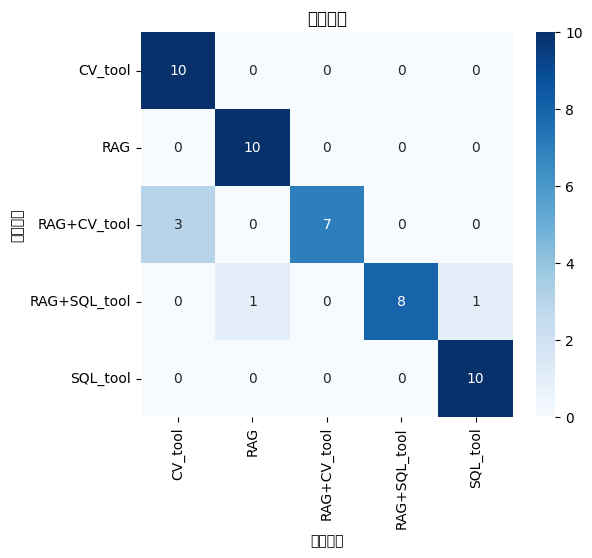

In [21]:
if results_df.empty:
    raise ValueError("results_df 为空，请先运行上一节推理单元。")

label_order = sorted({*results_df["reference_norm"], *results_df["predicted"]})
accuracy = accuracy_score(results_df["reference_norm"], results_df["predicted"])
print(f"整体准确率：{accuracy:.3f}")
print("分类报告：")
print(classification_report(results_df["reference_norm"], results_df["predicted"], labels=label_order, zero_division=0))

cm = pd.crosstab(results_df["reference_norm"], results_df["predicted"], dropna=False)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("预测意图")
plt.ylabel("真实意图")
plt.title("混淆矩阵")
plt.show()


## 6. 成本估算


In [24]:
total_prompt_tokens = int(results_df["prompt_tokens"].sum())
total_completion_tokens = int(results_df["completion_tokens"].sum())
total_cost_prompt = (total_prompt_tokens / 1000) * PRICE_PROMPT_PER_1K
total_cost_completion = (total_completion_tokens / 1000) * PRICE_COMPLETION_PER_1K
total_cost = total_cost_prompt + total_cost_completion
avg_cost_per_query = total_cost / len(results_df)

print("=== Price")


print("=== Token Usage & Cost Summary ===")
print(f"Prompt tokens:	{total_prompt_tokens:,}")
print(f"Completion tokens:	{total_completion_tokens:,}")
print(f"Prompt cost:	${total_cost_prompt:.14f}")
print(f"Completion cost:	${total_cost_completion:.14f}")
print(f"Total cost:	${total_cost:.14f}")
print(f"Avg cost / query:	${avg_cost_per_query:.14f}")



=== Price
=== Token Usage & Cost Summary ===
Prompt tokens:	0
Completion tokens:	0
Prompt cost:	$0.00000000000000
Completion cost:	$0.00000000000000
Total cost:	$0.00000000000000
Avg cost / query:	$0.00000000000000


## 7. 误分类样本与备注
通过筛选 `is_correct == False` 的数据，可快速定位模型仍需改进的案例。


In [25]:
error_cases = results_df[~results_df["is_correct"]]
print(f"误分类样本：{len(error_cases)} 条")
display(error_cases[["text", "reference", "predicted", "model_output", "source"]].head(10))


误分类样本：5 条


,text,reference,predicted,model_output,source
25,Provide reasoning for decreased mowing hours u...,RAG+SQL_tool,RAG,RAG,api
29,Summarize if Q3 2024 mowing costs meet operati...,RAG+SQL_tool,SQL_tool,SQL_tool,api
30,Look at this picture and explain whether mowin...,RAG+CV_tool,CV_tool,CV_tool,api
32,Analyze this field photo and describe what mai...,RAG+CV_tool,CV_tool,CV_tool,api
38,"Using this image, decide if the area needs mow...",RAG+CV_tool,CV_tool,CV_tool,api


## 下一步建议
- 针对误分类样本，分析模型是否缺少上下文、提示词是否需补充更细的决策规则。
- 若要比较不同模型或提示词，可复制本 Notebook，修改 `MODEL_NAME` 与 `SYSTEM_PROMPT` 后再次运行。
- 将 `experiment/results/` 中的 CSV 与缓存纳入版本管理或归档，便于团队复现本次实验。
